In [32]:
## Predicting Volcanic Eruption M-Modeling

## The problem:
# Volcanic eruptions happen at random times. What if we are able to predict the next one?
# Scientists identify "time to eruption" by analyzing volcano tremors from seismic signals. 
# In some volcanoes, this intesifies as volcanoes prepare to erupt; however patters of seismic actvity 
# are difficult to interpret. Currently, in active volcanos, scientists are able to predict eruptions 
# some minutes in advance but usually fall short in longer term durations. 

## Data: 
# We will be using kaggle's dataset: 
# https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/data

#Note: StandardScalar has already been applied to data

In [33]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

In [76]:
data_train_org = pd.read_csv('../Capstone_Two_Pre-processing/data_train.csv')

In [77]:
data_train_org = data_train_org.drop(['Unnamed: 0','segment_id', 'time_to_eruption'], axis=1)

In [78]:
data_train_org

,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_20,sensor_1_40,sensor_1_60,sensor_1_80,sensor_1_max,sensor_2_mean,sensor_2_std,...,sensor_9_80,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_20,sensor_10_40,sensor_10_60,sensor_10_80,sensor_10_max
0,-1.610323,303.096099,-1421.0,-249.0,-72.0,72.0,249.0,1353.0,4.613823,678.330828,...,306.0,2021.0,2.599440,596.865818,-3527.0,-503.0,-151.0,159.0,507.0,2187.0
1,1.426126,438.360560,-2005.0,-333.0,-96.0,100.0,338.0,2197.0,2.484442,661.163255,...,321.6,2189.0,19.895518,932.699662,-4591.0,-692.0,-202.0,205.0,710.0,5319.0
2,2.504592,241.575415,-1115.0,-195.0,-58.0,58.0,199.0,1148.0,5.449709,831.469221,...,199.0,1778.0,0.968101,500.544892,-2798.0,-402.0,-121.0,120.0,403.0,2522.0
3,2.165797,221.967825,-1025.0,-171.0,-50.0,52.0,177.0,1254.0,-0.373377,425.189594,...,189.0,1340.0,8.381444,523.449843,-2911.0,-400.0,-121.0,122.0,407.0,3614.0
4,0.073815,261.695935,-1190.0,-216.0,-63.0,62.0,212.0,1114.0,0.000000,0.000000,...,212.0,7725.0,-3.740471,562.748316,-2611.0,-458.0,-134.0,134.0,449.0,3274.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.906735,613.427301,-2610.0,-511.0,-155.0,155.0,518.0,2916.0,-3.658256,940.746578,...,471.0,3085.0,-3.377394,1053.539787,-5726.0,-839.0,-249.0,240.0,838.0,5493.0
4427,7.936884,649.089618,-3654.0,-521.0,-157.0,157.0,534.0,4498.0,0.000000,0.000000,...,623.0,32767.0,10.939634,1279.909391,-13017.0,-976.0,-298.0,294.0,984.0,14873.0
4428,1.420993,110.942596,-753.0,-87.0,-25.0,27.0,90.0,557.0,0.446893,505.722491,...,103.0,897.0,-1.550374,251.560198,-1708.0,-187.0,-56.0,56.0,184.0,1549.0
4429,0.905818,478.852581,-3555.0,-354.0,-105.0,105.0,354.0,3938.0,0.000000,0.000000,...,227.0,2015.0,-6.360564,618.914657,-3588.0,-501.0,-153.0,145.0,490.0,3628.0


In [34]:
df = pd.read_csv('standard_data_train_new.csv')

In [35]:
df.head()

,Unnamed: 0,segment_id,time_to_eruption,hr:min:sec,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_20,sensor_1_40,sensor_1_60,...,sensor_9_80,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_20,sensor_10_40,sensor_10_60,sensor_10_80,sensor_10_max
0,0,1136037770,12262005,1 days 10:03:40.050000,-0.060621,-0.230021,0.357337,0.20711,0.212498,-0.211514,...,-0.161021,-0.222131,0.085696,-0.254274,0.330534,0.208156,0.204763,-0.187325,-0.205860,-0.588104
1,1,1969647810,32739612,3 days 18:56:36.120000,0.108923,-0.140805,0.236445,0.14243,0.149976,-0.138809,...,-0.149522,-0.187689,0.586107,-0.069335,0.126223,0.091265,0.098232,-0.091724,-0.080167,0.017511
2,2,1895879680,14965999,1 days 17:34:19.990000,0.169141,-0.270598,0.420682,0.24869,0.248970,-0.247866,...,-0.239898,-0.271949,0.038498,-0.307316,0.470517,0.270622,0.267427,-0.268377,-0.270254,-0.523327
3,3,2068207140,26469720,3 days 01:31:37.200000,0.150224,-0.283530,0.439312,0.26717,0.269811,-0.263446,...,-0.247270,-0.361744,0.252981,-0.294703,0.448819,0.271858,0.267427,-0.264221,-0.267777,-0.312174
4,4,192955606,31072429,3 days 14:18:44.290000,0.033415,-0.257327,0.405156,0.23252,0.235944,-0.237480,...,-0.230315,0.947254,-0.097730,-0.273062,0.506425,0.235987,0.240273,-0.239282,-0.241772,-0.377918


In [36]:
#data_train = df.drop('Unnamed: 0', 1)
data_train = df.drop(['Unnamed: 0', 'segment_id', 'time_to_eruption', 'hr:min:sec'], axis = 1)

In [37]:
data_train.head()

,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_20,sensor_1_40,sensor_1_60,sensor_1_80,sensor_1_max,sensor_2_mean,sensor_2_std,...,sensor_9_80,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_20,sensor_10_40,sensor_10_60,sensor_10_80,sensor_10_max
0,-0.060621,-0.230021,0.357337,0.20711,0.212498,-0.211514,-0.207026,-0.374083,0.048251,-0.166989,...,-0.161021,-0.222131,0.085696,-0.254274,0.330534,0.208156,0.204763,-0.187325,-0.205860,-0.588104
1,0.108923,-0.140805,0.236445,0.14243,0.149976,-0.138809,-0.138064,-0.201596,0.018507,-0.176533,...,-0.149522,-0.187689,0.586107,-0.069335,0.126223,0.091265,0.098232,-0.091724,-0.080167,0.017511
2,0.169141,-0.270598,0.420682,0.24869,0.248970,-0.247866,-0.245768,-0.415979,0.059927,-0.081849,...,-0.239898,-0.271949,0.038498,-0.307316,0.470517,0.270622,0.267427,-0.268377,-0.270254,-0.523327
3,0.150224,-0.283530,0.439312,0.26717,0.269811,-0.263446,-0.262815,-0.394316,-0.021412,-0.307726,...,-0.247270,-0.361744,0.252981,-0.294703,0.448819,0.271858,0.267427,-0.264221,-0.267777,-0.312174
4,0.033415,-0.257327,0.405156,0.23252,0.235944,-0.237480,-0.235695,-0.422927,-0.016197,-0.544116,...,-0.230315,0.947254,-0.097730,-0.273062,0.506425,0.235987,0.240273,-0.239282,-0.241772,-0.377918


In [38]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sensor_1_mean   4431 non-null   float64
 1   sensor_1_std    4431 non-null   float64
 2   sensor_1_min    4431 non-null   float64
 3   sensor_1_20     4431 non-null   float64
 4   sensor_1_40     4431 non-null   float64
 5   sensor_1_60     4431 non-null   float64
 6   sensor_1_80     4431 non-null   float64
 7   sensor_1_max    4431 non-null   float64
 8   sensor_2_mean   4431 non-null   float64
 9   sensor_2_std    4431 non-null   float64
 10  sensor_2_min    4431 non-null   float64
 11  sensor_2_20     4431 non-null   float64
 12  sensor_2_40     4431 non-null   float64
 13  sensor_2_60     4431 non-null   float64
 14  sensor_2_80     4431 non-null   float64
 15  sensor_2_max    4431 non-null   float64
 16  sensor_3_mean   4431 non-null   float64
 17  sensor_3_std    4431 non-null   f

In [39]:
#labels
y_train = df['time_to_eruption']

In [42]:
#Training Models:

#LinearRegression
linear_model = LinearRegression()
linear_model.fit(data_train,y_train)
print(linear_model.score(data_train,y_train))

0.21786763258042774


In [45]:
#RandomForestRegressor

forest_model = RandomForestRegressor()
forest_model.fit(data_train,y_train)
print(forest_model.score(data_train,y_train))

0.9711720032990379


In [46]:
#LGB

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(data_train,y_train)
print(lgb_model.score(data_train,y_train))

0.9436990193829349


In [47]:
#GradientBoostingRegressor

gradientboost_model = GradientBoostingRegressor()
gradientboost_model.fit(data_train,y_train)
print(gradientboost_model.score(data_train,y_train))

0.7149113902004618


In [48]:
#DecisionTreeRegressor

decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(data_train,y_train)
print(decision_tree_model.score(data_train,y_train))

1.0


In [50]:
#Applying GridSearchCV for hyperparameter tuning for model:

#RandomForestRegressor

Rfr_pipeline = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',RandomForestRegressor(random_state = 42))])

Rfr_grid_search = GridSearchCV(estimator = Rfr_pipeline, param_grid = {'selector__k':[70] , 
  'model__n_estimators':np.arange(500,550,50),'model__max_depth':[15]}, n_jobs=-1,
                                  scoring="neg_mean_squared_error", cv=20, verbose=3)

In [51]:
Rfr_grid_search.fit(data_train,y_train)
print('the best parameters : ',Rfr_grid_search.best_params_)
print('the best score = ', np.sqrt(-Rfr_grid_search.best_score_))

Fitting 20 folds for each of 1 candidates, totalling 20 fits
the best parameters :  {'model__max_depth': 15, 'model__n_estimators': 500, 'selector__k': 70}
the best score =  6026984.752390339


In [52]:
#LGB

lgb_pipeline = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',lgb.LGBMRegressor(random_state=42,objective='regression',
                              bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))])

lgb_grid_search = GridSearchCV( estimator = lgb_pipeline, param_grid = {'selector__k':[70] , 
  'model__learning_rate':[0.01],'model__num_iterations':[10000],'model__n_estimators':[500],
                            'model__max_bin':[100],'model__num_leaves':[40,50]},
                               n_jobs=-1, scoring="neg_mean_squared_error", cv=20, verbose=3)

In [53]:
lgb_grid_search.fit(data_train,y_train)
print('the best parameters : ',lgb_grid_search.best_params_)
print('the best score = ', np.sqrt(-lgb_grid_search.best_score_))

Fitting 20 folds for each of 2 candidates, totalling 40 fits


/opt/anaconda3/envs/Springboard_Env/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
the best parameters :  {'model__learning_rate': 0.01, 'model__max_bin': 100, 'model__n_estimators': 500, 'model__num_iterations': 10000, 'model__num_leaves': 50, 'selector__k': 70}
the best score =  4946314.297767813


In [54]:
#DecisionTreeRegressor

dtr_pipeline = Pipeline([
     ('selector',SelectKBest(f_regression)),
     ('model',DecisionTreeRegressor(random_state = 42))])

dtr_grid_search = GridSearchCV( estimator = dtr_pipeline, param_grid = {'selector__k':[70,80] , 
     'model__max_depth':[12,13,15]}, n_jobs=-1,scoring="neg_mean_squared_error", cv=20, verbose=3)

In [55]:
dtr_grid_search.fit(data_train,y_train)
print('the best parameters : ',dtr_grid_search.best_params_)
print('the best score = ', np.sqrt(-dtr_grid_search.best_score_))

Fitting 20 folds for each of 6 candidates, totalling 120 fits
the best parameters :  {'model__max_depth': 12, 'selector__k': 70}
the best score =  8968035.365579043


In [56]:
#Model for test

test = pd.read_csv('../volcanic_data/sample_submission.csv')

In [58]:
def make_data():
    global test
    n = 0
    for  i in test.segment_id :
        file = pd.read_csv('../volcanic_data/test/{}.csv'.format(i))
        for x in file.columns:
            test.loc[n:n+1,x+'_mean'] = file[x].mean()
            test.loc[n,x+'_std'] = file[x].std()
            test.loc[n,x+'_min'] = file[x].min()
            test.loc[n,x+'_20'] = file[x].quantile(0.20)
            test.loc[n,x+'_40'] = file[x].quantile(0.40)
            test.loc[n,x+'_50'] = file[x].quantile(0.50)
            test.loc[n,x+'_60'] = file[x].quantile(0.60)
            test.loc[n,x+'_80'] = file[x].quantile(0.80)
            test.loc[n,x+'_max'] = file[x].max()
        n +=1

    test.fillna(0,inplace=True)
    return test
make_data() 

,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_20,sensor_1_40,sensor_1_50,sensor_1_60,sensor_1_80,...,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_20,sensor_10_40,sensor_10_50,sensor_10_60,sensor_10_80,sensor_10_max
0,1000213997,0,4.462476,306.174474,-1319.0,-244.0,-72.0,0.0,73.0,252.0,...,1630.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100023368,0,0.838103,335.591100,-1268.0,-287.0,-84.0,0.0,87.0,289.0,...,1164.0,-5.790420,569.068331,-2502.0,-482.0,-145.0,0.0,139.0,469.0,2820.0
2,1000488999,0,0.794903,352.172248,-3806.0,-243.0,-71.0,0.0,72.0,245.0,...,912.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001028887,0,1.953717,259.030122,-1156.0,-216.0,-66.0,0.0,66.0,221.0,...,1144.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001857862,0,-3.984584,254.306426,-1111.0,-215.0,-62.0,0.0,62.0,209.0,...,1301.0,-0.178297,525.529733,-2638.0,-437.0,-130.0,0.0,130.0,434.0,2265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,996704281,0,-135.674672,29486.243321,-32767.0,-32767.0,-24181.0,0.0,22281.0,32767.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4516,997630809,0,-2.666439,294.261065,-1291.0,-250.0,-75.0,0.0,74.0,244.0,...,1750.0,3.488892,535.872551,-2242.0,-441.0,-132.0,0.0,134.0,448.0,2486.0
4517,998072137,0,1.192280,371.072752,-3032.0,-285.0,-82.0,0.0,83.0,285.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4518,998136924,0,3.218563,346.656999,-1423.0,-278.0,-81.0,0.0,81.0,279.0,...,1341.0,9.977984,808.310113,-4349.0,-636.0,-192.0,0.0,194.0,659.0,3898.0


In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4520 entries, 0 to 4519
Data columns (total 92 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   segment_id        4520 non-null   int64  
 1   time_to_eruption  4520 non-null   int64  
 2   sensor_1_mean     4520 non-null   float64
 3   sensor_1_std      4520 non-null   float64
 4   sensor_1_min      4520 non-null   float64
 5   sensor_1_20       4520 non-null   float64
 6   sensor_1_40       4520 non-null   float64
 7   sensor_1_50       4520 non-null   float64
 8   sensor_1_60       4520 non-null   float64
 9   sensor_1_80       4520 non-null   float64
 10  sensor_1_max      4520 non-null   float64
 11  sensor_2_mean     4520 non-null   float64
 12  sensor_2_std      4520 non-null   float64
 13  sensor_2_min      4520 non-null   float64
 14  sensor_2_20       4520 non-null   float64
 15  sensor_2_40       4520 non-null   float64
 16  sensor_2_50       4520 non-null   float64


In [60]:
segment_id_final = test['segment_id']

In [61]:
test.drop(['time_to_eruption','segment_id', 'sensor_1_50', 'sensor_2_50', 'sensor_3_50','sensor_4_50', 'sensor_5_50', 'sensor_6_50', 
           'sensor_7_50', 'sensor_8_50', 'sensor_9_50', 'sensor_10_50'], axis=1, inplace=True)

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4520 entries, 0 to 4519
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sensor_1_mean   4520 non-null   float64
 1   sensor_1_std    4520 non-null   float64
 2   sensor_1_min    4520 non-null   float64
 3   sensor_1_20     4520 non-null   float64
 4   sensor_1_40     4520 non-null   float64
 5   sensor_1_60     4520 non-null   float64
 6   sensor_1_80     4520 non-null   float64
 7   sensor_1_max    4520 non-null   float64
 8   sensor_2_mean   4520 non-null   float64
 9   sensor_2_std    4520 non-null   float64
 10  sensor_2_min    4520 non-null   float64
 11  sensor_2_20     4520 non-null   float64
 12  sensor_2_40     4520 non-null   float64
 13  sensor_2_60     4520 non-null   float64
 14  sensor_2_80     4520 non-null   float64
 15  sensor_2_max    4520 non-null   float64
 16  sensor_3_mean   4520 non-null   float64
 17  sensor_3_std    4520 non-null   f

In [79]:
std_scaler = StandardScaler()
scaler_data = std_scaler.fit_transform(data_train_org)

scaler_test = std_scaler.transform(test)
test = pd.DataFrame(scaler_test, columns = test.columns)

In [80]:
test

,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_20,sensor_1_40,sensor_1_60,sensor_1_80,sensor_1_max,sensor_2_mean,sensor_2_std,...,sensor_9_80,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_20,sensor_10_40,sensor_10_60,sensor_10_80,sensor_10_max
0,0.278462,-0.227990,0.378452,0.21096,0.212498,-0.208917,-0.204701,-0.375309,-0.016197,-0.544116,...,-0.198617,-0.302290,0.010489,-0.582959,1.007793,0.519247,0.520176,-0.517770,-0.519781,-1.010991
1,0.076090,-0.208588,0.389010,0.17785,0.181237,-0.172565,-0.176031,-0.402490,-0.016197,-0.544116,...,-0.208200,-0.397826,-0.157039,-0.269581,0.527356,0.221144,0.217296,-0.228890,-0.229389,-0.465705
2,0.073678,-0.197652,-0.136376,0.21173,0.215103,-0.211514,-0.210125,0.219814,-0.082419,-0.262558,...,-0.262013,-0.449489,0.010489,-0.582959,1.007793,0.519247,0.520176,-0.517770,-0.519781,-1.010991
3,0.138382,-0.259085,0.412194,0.23252,0.228129,-0.227094,-0.228721,-0.401264,-0.016197,-0.544116,...,-0.230315,-0.401926,0.010489,-0.582959,1.007793,0.519247,0.520176,-0.517770,-0.519781,-1.010991
4,-0.193190,-0.262201,0.421510,0.23329,0.238549,-0.237480,-0.238020,-0.451948,-0.062386,-0.129197,...,-0.198617,-0.369739,0.005331,-0.293557,0.501241,0.248975,0.248628,-0.247595,-0.251060,-0.573022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,-7.546267,19.018172,-6.131529,-24.83186,-62.594059,57.456345,24.989559,6.045972,-13.974379,10.005586,...,-0.386594,-0.636459,0.010489,-0.582959,1.007793,0.519247,0.520176,-0.517770,-0.519781,-1.010991
4516,-0.119590,-0.235848,0.384248,0.20634,0.204683,-0.206321,-0.210900,-0.439686,0.004029,-0.107636,...,-0.181662,-0.277689,0.111430,-0.287862,0.577281,0.246501,0.244450,-0.239282,-0.242391,-0.530288
4517,0.095866,-0.185186,0.023848,0.17939,0.186447,-0.182951,-0.179131,-0.110856,-0.028560,-0.393673,...,-0.386594,-0.636459,0.010489,-0.582959,1.007793,0.519247,0.520176,-0.517770,-0.519781,-1.010991
4518,0.209006,-0.201290,0.356923,0.18478,0.189052,-0.188145,-0.183780,-0.345267,-0.023920,-0.225498,...,-0.203777,-0.361539,0.299172,-0.137834,0.172693,0.125899,0.119120,-0.114585,-0.111745,-0.257259


In [81]:
#Final model for lgb

lgb_final = lgb_grid_search.best_estimator_

In [82]:
lgb_y = lgb_final.predict(test)

In [83]:
results = pd.DataFrame()
results['segment_id'] = segment_id_final
results['time_to_eruption'] = lgb_y
results.to_csv('final_results.csv', index=False)

In [1]:
#We chose lgb because it gave us the best cross validation score. Compared to the score of 4946314.297767813,
#our score was 6311987 after running the test data for submission. One of the reasons for this high score is
#possible the amount of features used. If more features were used,  I suspect that the score would be lower.

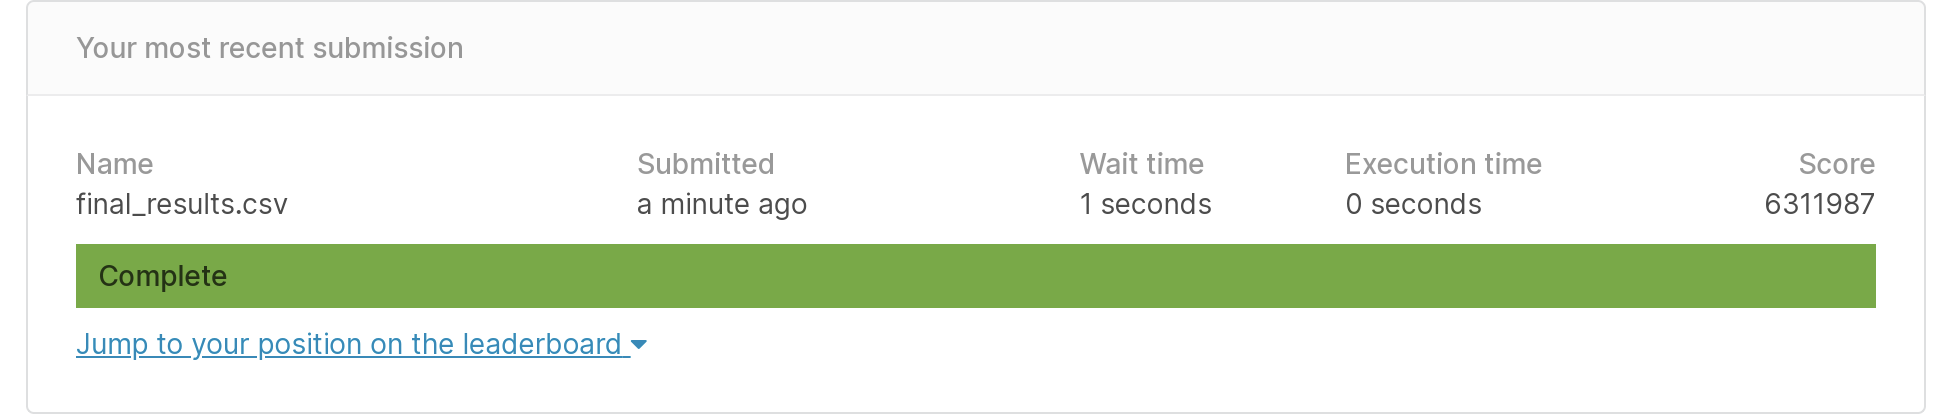